In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from random import randint
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import pickle

In [2]:
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
string.split('\n')
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [3]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

Create a pipeline such that when the user enters a song, you:

    1. Check whether or not the song is in the Billboard Hot 200.
    2. Collect the audio features from the Spotify API.

After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

In [4]:
hot_songs = pd.read_csv('hot_songs.csv', index_col=0)

In [5]:
#import songs df
songs = pd.read_csv('songs.csv', index_col=0)
#drop title, artist, uri columns from train set
X = songs.drop(['title', 'artist', 'uri'], axis=1)

In [6]:
#scale features
ss = StandardScaler()
X= ss.fit_transform(X)

Text(0, 0.5, 'inertia')

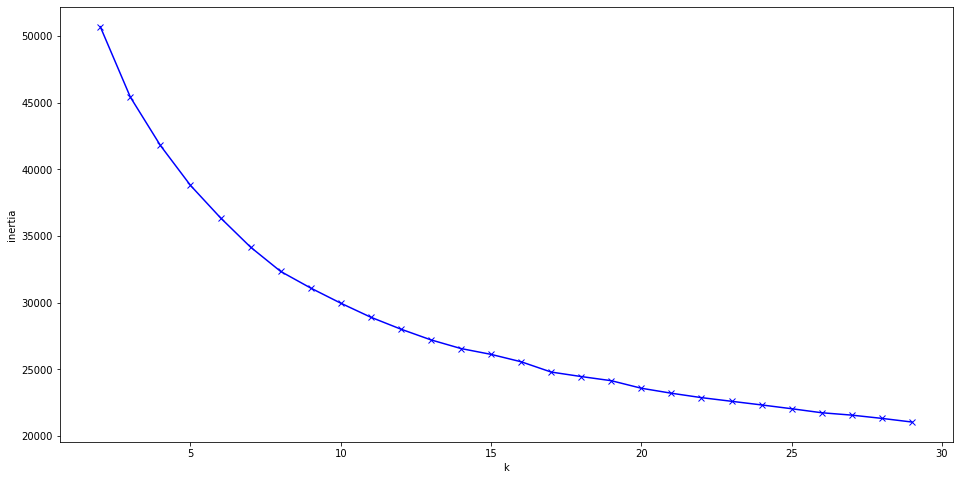

In [7]:
#create cluster model

#try KMeans with optimal k for inertia score
K = range(2, 30)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=18)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')

In [8]:
#there is no obvious elbow in the chart for inertia score...

Text(0, 0.5, 'silhouette score')

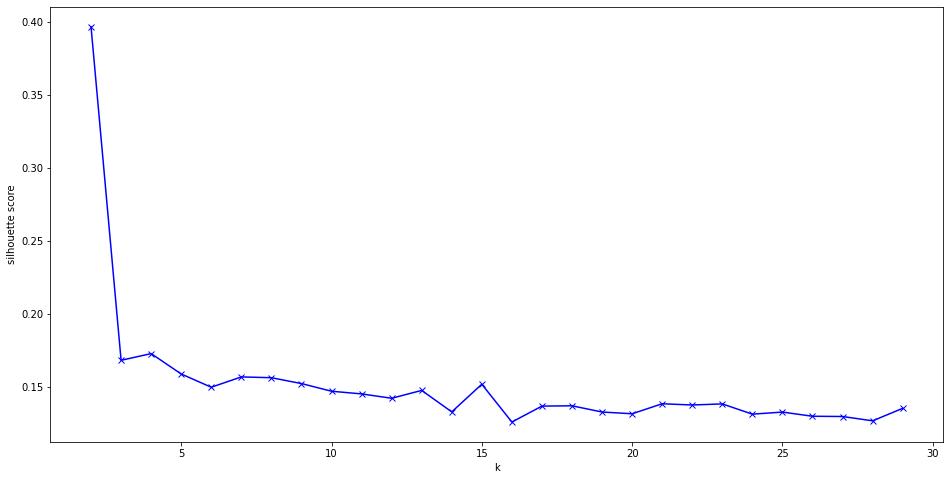

In [9]:
#try KMeans with optimal k for silhouette score
K = range(2, 30)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=18)
    kmeans.fit(X)
    silhouette.append(silhouette_score(X, kmeans.predict(X)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')

In [ ]:
#silhouette score for k=4 is higher, but I think k=15 is a better option because it will be better to have a greater number of song clusters 

In [10]:
#train KMeans model with optimal k
kmeans = KMeans(n_clusters=15,
                    random_state=18)
kmeans.fit(X)
#add clusters to the song df
pred = kmeans.predict(X)
songs['kmeans_cluster'] = pred

In [11]:
#try DBScan clustering model
db = cluster.DBSCAN(eps = 5.5, min_samples= 5)
pred = db.fit_predict(X)
score = silhouette_score(X, pred)
score
#can't do min_sample size of more than 5... and eps between .43 and 5.5

#eps=5.5, min_samples=5. score .536
songs['dbscan_cluster'] = pred

In [12]:
songs.dbscan_cluster.value_counts()

0    5527
1      35
Name: dbscan_cluster, dtype: int64

In [13]:
#try Gaussian mixture clustering model
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(2, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [14]:
lowest_bic

-34758.76048961558

In [15]:
best_gmm

GaussianMixture(covariance_type='diag', n_components=19)

In [16]:
pred = best_gmm.fit_predict(X)
songs['gm_cluster'] = pred

In [17]:
songs.gm_cluster.value_counts() 

14    839
1     779
18    738
6     727
11    421
5     373
3     322
4     297
2     228
15    206
0     156
7     135
12     90
13     76
16     68
8      32
10     31
9      28
17     16
Name: gm_cluster, dtype: int64

In [ ]:
#kmeans: 15 clusters with between 35-638 songs in each cluster
#dbscan: 2 clusterw with 35 songs in one and 5527 songs in another
#gaussian mixture: 17 clusters with 16-1090 songs in each cluster

In [ ]:
#I am choosing the KMeans cluster as I think it is preferred to have many smaller clusters of more similar songs than a few larger clusters. 

In [ ]:
#build song recommender

In [36]:
def song_recommender():
    song_input=input('Enter a song: ')
    if song_input in hot_songs.title.values:
        n = random.randint(0,len(hot_songs))
        reco_song_title = hot_songs.title[n]
        reco_song_artist = hot_songs.artist[n]
        return f"We recommend {reco_song_title} by {reco_song_artist}."
    
    else:
        #get uri
        results = sp.search(q= song_input, limit=1, type='track')
        if results['tracks']['total'] != 0:
            uri = results['tracks']['items'][-1]['uri']
        else: 
            return f"{song_input} not found on Spotify"

        #get audio features using uri
        song_details = sp.audio_features(uri)
        song_features = song_details[0]
        audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'time_signature']
        song_af = {f:song_features[f] for f in audio_features}
        af = pd.DataFrame(song_af, index=[0])
        
        #scale audio features
        af=ss.transform(af)
        
        #find cluster
        pred_cluster = kmeans.predict(af)
        
        #suggest song from that cluster
        cluster_songs = songs[songs['kmeans_cluster'] == pred_cluster[0]]
        cluster_songs.reset_index(inplace=True, drop=True)
        n = randint(0,len(cluster_songs))
        reco_song_title = cluster_songs.iloc[n].title
        reco_song_artist = cluster_songs.iloc[n].artist
        return f"We recommend '{reco_song_title}' by {reco_song_artist}."
    
    

In [39]:
song_recommender()

Enter a song: Happy


"We recommend 'High Horse (feat. BRELAND and Blanco Brown)' by Nelly."

In [40]:
#pickle the scaler and model
filename1 = 'gnod_scaler.sav'
pickle.dump(ss, open(filename1, 'wb'))

filename2 = 'gnod_kmeans_model.sav'
pickle.dump(kmeans, open(filename2, 'wb'))

In [41]:
songs.to_csv('clustered_songs.csv')